In [1]:
import sys

# Specify the directory you want to add
custom_path = './..'

# Add the directory to sys.path
if custom_path not in sys.path:
    sys.path.append(custom_path)

In [2]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!ls

DELETE_THIS_empty.ipynb
ZZZZ_nl_experiments_tanh.ipynb
ZZZ_bkp_oldReLU.ipynb
ZZZ_delete_nl_experiments-Copy4.ipynb
__init__.py
antifrog_demo.ipynb
avraham_data_bringup.ipynb
basline_example_forDK.ipynb
collect_fitting_clean_nans.ipynb
collect_fitting_info101-3a-BUGBUG.ipynb
collect_fitting_info101-3a-val.ipynb
collect_fitting_info101-3a-val_shiftLeft.ipynb
collect_fitting_info101-3a.ipynb
collect_fitting_info101-repa.ipynb
collect_fitting_info101.ipynb
collect_fittings_to_avraham.ipynb
debug_full_repertoire.ipynb
fit_single_v1.py
focus_on_comboNerr_sweeps.ipynb
focus_on_combo_sweeps.ipynb
focus_on_error_learning.ipynb
focus_on_error_learning_gauss.ipynb
focus_on_error_learning_sweeps.ipynb
focus_on_error_learning_sweeps_pureLinReg.ipynb
frog_gain.ipynb
full_parallel_nns.ipynb
full_parallel_nns_experimental.ipynb
full_repertoire_dual_rate.ipynb
full_repertoire_focus_wc.ipynb
full_repertoire_skip_study.ipynb
gauss_kernel_encoder.ipynb
hello_world_fitting.ipynb
hello_world_fitting102.ipyn

In [4]:
opt_data = {}
for i in range(24):
    with open(f'../results/sweek_with_shift_{i}.pkl','rb') as f:
        opt_data[i] = pickle.load(f)

In [5]:
opt_data

{0: {'MSE':                         fun: 141.0884859795394
   lowest_optimization_result:       fun: 141.0884859795394
   hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
        jac: array([ 2.90442414e+02,  0.00000000e+00,  0.00000000e+00, -1.39263523e-01])
    message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 160
        nit: 5
       njev: 32
     status: 0
    success: True
          x: array([-4.67886002, -0.74839045,  0.23886905, 42.78987478])
                      message: ['requested number of basinhopping iterations completed successfully']
        minimization_failures: 3
                         nfev: 11350
                          nit: 100
                         njev: 2270
                            x: array([-4.67886002, -0.74839045,  0.23886905, 42.78987478])},
 1: {'MSE':                         fun: 118.82157968386548
   lowest_optimization_result:       fun: 118.82157968386548
   hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
  

In [6]:
def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
fixed_params = {}
fixed_params['model'] =  dict(n_inputs = 3,
        n_hidden = 5*4*512,
        n_outs = 1,
        en_bias = False,
        b_high=3, first_layer_init='ones',
        first_layer_weights_trainable = True,
        out_layer_init='zeros')         

fixed_params['runner'] = {'criterion':'MSE', 'k':[0,1,0], 'sigma_noi':0.0, 'tau_u':1,
                        'save_model_at_init':False, 'ic_param_file':None}

optim_param_mapping= [('custom','normalized_log_lr'),
                    ('model','skip_gain'),                      
                    ('custom','w'),
                    ('postprocessing','scale'),
                    ]

custom_param_mappings = [{'cathegory':'runner','param_name':'learning_rate',
                            'fun': lambda x: 10.**x['normalized_log_lr']}]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                              custom_param_mappings =custom_param_mappings,
                                             postprocessing_fun=scale_and_bias)


In [7]:
df = pd.read_csv('../../../frogs_project/data/avraham__ivry_fig1_rotFig1_v2.csv',header=None)
df = df.T
data = df.to_numpy()

In [8]:
stimulus = [(1,40),(0,40)]
pooling_fun = 'MSE'

In [9]:
errors = [opt_data[k][pooling_fun]['fun'] for k in opt_data]


In [10]:
np.mean(errors)

69.63715568181459

In [11]:
outs  = {k: wrapped_runner([(1,40),(0,40),(1,41)],opt_data[k][pooling_fun]['x']) for k in opt_data}

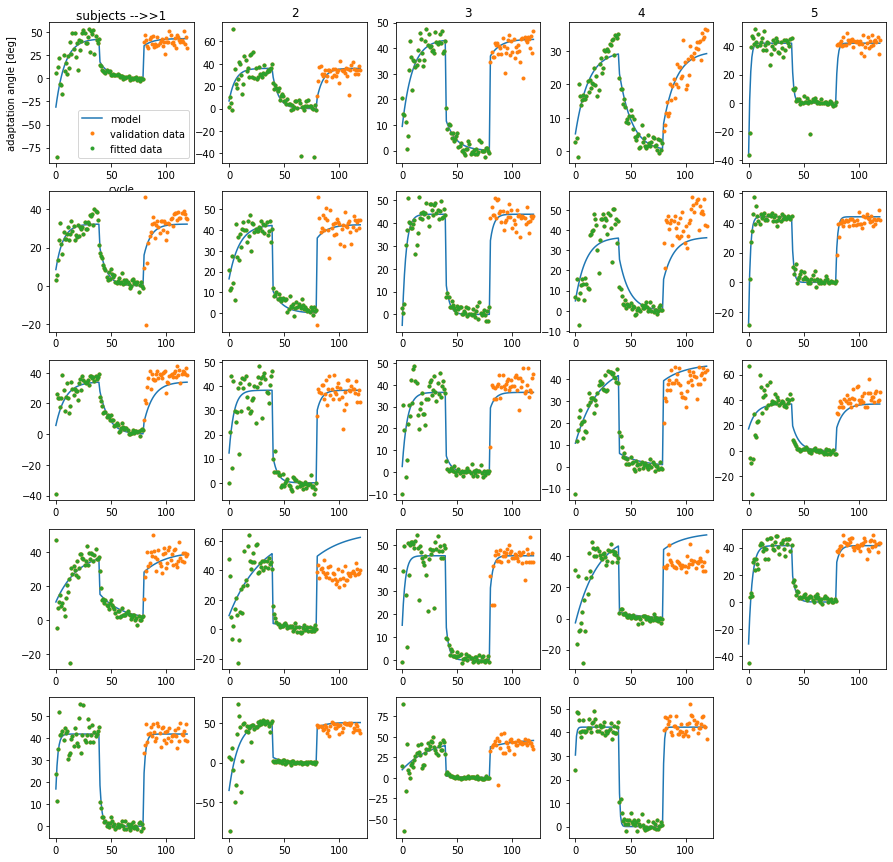

In [37]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k][1:])
    plt.plot(data[:,k],'.')
    plt.plot(data[:80,k],'.')
    if k<5: plt.title(f'{k+1}')
        

plt.subplot(5,5,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-30)
plt.legend(['model','validation data','fitted data'])    
    
# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


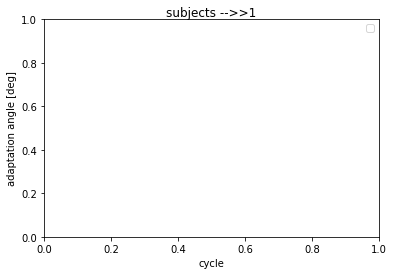

In [34]:
plt.subplot(1,1,1)
plt.ylabel('adaptation angle [deg]')
plt.xlabel('cycle')

plt.gca().set_title(f'subjects -->>{1}', pad=-3000)
plt.legend(['model','validation data','fitted data']) 

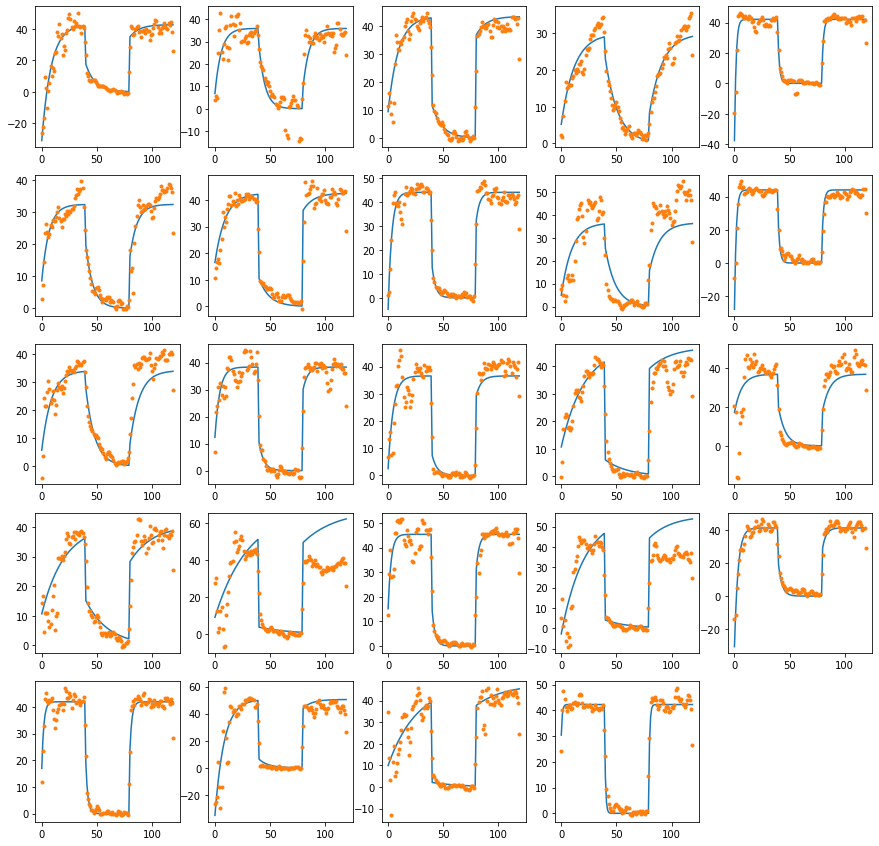

In [13]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k][1:])
    plt.plot(smooth_signal(data[:,k],3),'.')

In [14]:
outs_ = [o[1:] for _,o in outs.items()]
outs_ = np.array(outs_)

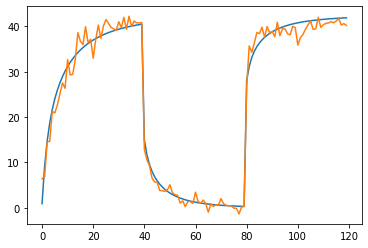

In [15]:
plt.plot(np.mean(outs_,axis=0))
plt.plot(np.mean(data,axis=1))

In [16]:
diffs = outs_.T-data
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2)

(69.63715568182214, 71.17979145353007)

In [17]:
data_varia = data-np.mean(data,axis=1,keepdims=True)

In [18]:
np.mean(data_varia**2)

83.27901569878472

In [19]:
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2),np.mean(diffs[81:,:]**2)

(69.63715568182214, 71.17979145353007, 68.28443689744066)

In [20]:
np.mean(data_varia[:80,:]**2),np.mean(data_varia[80:,:]**2),np.mean(data_varia[81:,:]**2)

(99.77897536675346, 50.27909636284723, 46.55323259882478)

[]

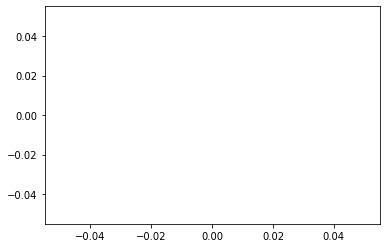

In [21]:
plt.plot(diffs[:,80:])

In [22]:
A_times = [0,5,10,20] 
antero   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

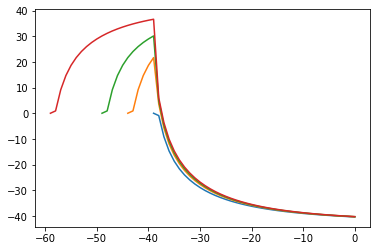

In [23]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [24]:
frog_ens = [True,False]
Tfrog = 120
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

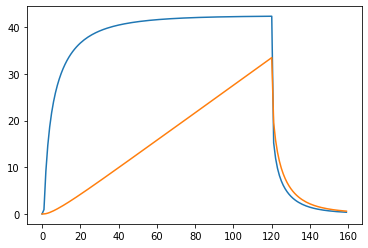

In [25]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [26]:
for setting in pooling_funs +[appendix]:
    plt.plot(outs[setting])
plt.plot(data[:,0],'x')
plt.plot(data[:80,0],'x')

plt.xlim([39,120])
plt.ylim([-5,60])


NameError: name 'pooling_funs' is not defined

In [ ]:
mae = lambda x: np.mean(np.abs(x))
mse = lambda x: np.mean(np.square(x))


In [ ]:
for setting in pooling_funs +[appendix]:
    fit_err = outs[setting][:80] - data[:80,0]
    val_err = outs[setting][80:] - data[80:,0]
    print(f'fit objective: {setting}')
    print(f' fitting MAE: {mae(fit_err)}; MSE: {mse(fit_err)}')
    print(f' validation MAE: {mae(val_err)}; MSE: {mse(val_err)}')

In [ ]:
import scipy
scipy.__version__

In [ ]:
# !pip3 install --upgrade pip

In [ ]:
# pip install --upgrade scipy

In [ ]:
import pickle

In [ ]:
with open('sweep_1_subj_12.pkl','rb') as f:
    opt_data = pickle.load(f)

In [ ]:
opt_data